In [1]:
import librosa 
from librosa import display
import pylab as plt
import os
import pandas as pd
import glob
import numpy as np
from numpy import savetxt
from numpy import asarray
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [2]:
path ='.../RAVDESS'
emotion = []
emotion_code =[]
gender = []
actor = []
file_path = []
for subdir,dirs,files in os.walk(path):
    for file in files:
        part = file.split('.')[0].split('-')
        emotion.append(int(part[2]))
        emotion_code.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        # if bg%2 == 0:
        #    bg = "female"
        #else:
        #    bg = "male"
        gender.append(bg)
        file_path.append('.../RAVDESS/' + file)
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),pd.DataFrame(emotion_code),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion_code','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [3]:
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    df.loc[counter] = [db_spec]
    counter=counter+1
    
audio_df['mel_spectrogram']= df['mel_spectrogram']
print(audio_df.head())
print(audio_df.shape)

   gender  emotion_code   emotion  actor  \
0       2             6      fear      2   
1      16             5     angry     16   
2      16             3     happy     16   
3      14             8  surprise     14   
4       2             3     happy      2   

                                                path  \
0  /Users/xx/Desktop/5452 pro/RAVDESS/03-01-06-01...   
1  /Users/xx/Desktop/5452 pro/RAVDESS/03-01-05-01...   
2  /Users/xx/Desktop/5452 pro/RAVDESS/03-02-03-02...   
3  /Users/xx/Desktop/5452 pro/RAVDESS/03-01-08-01...   
4  /Users/xx/Desktop/5452 pro/RAVDESS/03-02-03-02...   

                                     mel_spectrogram  
0  [[-66.32325, -66.32325, -66.32325, -66.32325, ...  
1  [[-62.853226, -62.853226, -62.853226, -62.8532...  
2  [[-63.636585, -63.636585, -63.636585, -63.6365...  
3  [[-74.1957, -74.1957, -74.1957, -74.1957, -74....  
4  [[-60.580383, -60.461906, -58.998493, -54.4517...  
(2452, 6)


In [4]:
df2 = audio_df

In [5]:
to_drop = []
for i in range(2452):
    if df2['mel_spectrogram'].iloc[i].shape[1]!=259:
        to_drop.append(i)

df2 = df2.drop(to_drop)
print(df2.shape)

(2075, 6)


In [6]:
train,test = train_test_split(df2,test_size=0.2)
temp_X_train = train.iloc[:,5]
temp_X_test = test.iloc[:,5]

y_train = (train.iloc[:,0]%2 * 8 ) + train.iloc[:,1]
y_test = (test.iloc[:,0]%2 * 8 ) + test.iloc[:,1]

X_train = []
X_test = []

for i in range(temp_X_train.shape[0]):
    X_train.append(temp_X_train.iloc[i])

X_train = np.array(X_train)

for i in range(temp_X_test.shape[0]):
    X_test.append(temp_X_test.iloc[i])

X_test = np.array(X_test)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1660, 128, 259)
(1660,)
(415, 128, 259)
(415,)


In [7]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
DummyClassifier()
dummy_clf.predict(X_test)
print(dummy_clf.score(X_test, y_test))

0.07228915662650602


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
X_train = torch.from_numpy(X_train) 
y_train = torch.from_numpy(np.asarray(y_train)) 
X_test = torch.from_numpy(X_test) 
y_test = torch.from_numpy(np.asarray(y_test)) 

In [10]:
print(X_train.size())
print(y_train.size())

y_train = y_train-1
y_test = y_test-1

torch.Size([1660, 128, 259])
torch.Size([1660])


In [11]:
print(max(y_train))
print(y_test.shape)

tensor(15)
torch.Size([415])


In [12]:
mean= X_train.mean()

print(mean)

tensor(-43.0157)


In [13]:
std= X_train.std()

print(std)

tensor(20.0894)


In [ ]:
net = nn.Sequential(
        nn.Conv2d(1,   50,  kernel_size=3,  padding=1 ),
        nn.BatchNorm2d(50),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2,2),
       
        nn.Conv2d(50,  100,  kernel_size=3,  padding=1 ),
        nn.Dropout(0.5),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2,2),
        nn.Flatten(start_dim=1),
        nn.Linear(204800, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100,16),
)
# net=emotion_classifier()
print(net)
net = net.to(device)

mean=mean.to(device)

std=std.to(device)
criterion = nn.CrossEntropyLoss()

my_lr=0.001

bs= 10

In [15]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

In [16]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,415,bs):

        minibatch_data =  X_test[i:i+bs].unsqueeze(dim=1)
        minibatch_label= y_test[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std   

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'error rate on test set =', total_error*100 ,'percent')

In [37]:
X_g =[]
Y_ac_g = []
y_pre_g = []
tmp_X_g = df2.iloc[:,5]
tmp_y_g = df2.iloc[:,0]%2 * 8 + df2.iloc[:,1]
#(train.iloc[:,0]%2 * 8 ) + train.iloc[:,1]
target_names=["neutral", "calm", "happy", "sad", "angry", "fear", "disgust", "surprise"]

Y_ac_g = df2.iloc[:,0]%2 * 8 + df2.iloc[:,1]

for i in range(tmp_X_g.shape[0]):
    X_g.append(tmp_X_g.iloc[i])

X_g = np.array(X_g)

X_g = torch.from_numpy(X_g) 
Y_ac_g = torch.from_numpy(np.asarray(Y_ac_g))

Y_ac_g = Y_ac_g-1
print(X_g.shape)

torch.Size([2075, 128, 259])


In [38]:
def get_error_eval( scores ,gender, labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    #predicted_labels = predicted_labels -8
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches/bs 

In [39]:
print(X_g.shape)

torch.Size([2075, 128, 259])


In [40]:
#net = net.to(device)
net.load_state_dict(torch.load(".../gender100.pth"))
shuffled_indices=torch.randperm(X.shape[0])
 
#eval()

running_error=0
num_batches=0
y_pre_g = []

for i in range(0,X_g.shape[0],bs):

        minibatch_data =  X_g[i:i+bs].unsqueeze(dim=1)
        minibatch_label= Y_ac_g[i:i+bs]
        minibatch_gender=gender_para[i:i+bs]

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std   

        scores=net( inputs ) 
        
        ##(train.iloc[:,0]%2 * 8 ) + train.iloc[:,1]
        predicted_labels = scores.argmax(dim=1)
        y_pre_g.extend(predicted_labels)
        
        error = get_error_eval( scores, minibatch_gender, minibatch_label)

        running_error += error.item()

        num_batches+=1

total_error = running_error/num_batches
print( 'error rate on test set =', total_error*100 ,'percent')
print(y_pre_g)

error rate on test set = 4.855769987289722 percent
[tensor(5), tensor(4), tensor(2), tensor(7), tensor(2), tensor(5), tensor(4), tensor(1), tensor(3), tensor(3), tensor(0), tensor(1), tensor(1), tensor(3), tensor(3), tensor(1), tensor(5), tensor(4), tensor(7), tensor(2), tensor(1), tensor(5), tensor(4), tensor(6), tensor(2), tensor(5), tensor(7), tensor(7), tensor(5), tensor(7), tensor(2), tensor(4), tensor(2), tensor(4), tensor(5), tensor(4), tensor(5), tensor(2), tensor(3), tensor(6), tensor(1), tensor(1), tensor(3), tensor(6), tensor(3), tensor(6), tensor(1), tensor(0), tensor(1), tensor(0), tensor(3), tensor(6), tensor(5), tensor(4), tensor(5), tensor(4), tensor(2), tensor(2), tensor(6), tensor(1), tensor(3), tensor(3), tensor(1), tensor(0), tensor(6), tensor(8), tensor(14), tensor(11), tensor(9), tensor(9), tensor(11), tensor(13), tensor(12), tensor(10), tensor(13), tensor(12), tensor(8), tensor(9), tensor(14), tensor(11), tensor(14), tensor(11), tensor(8), tensor(9), tensor(9), t

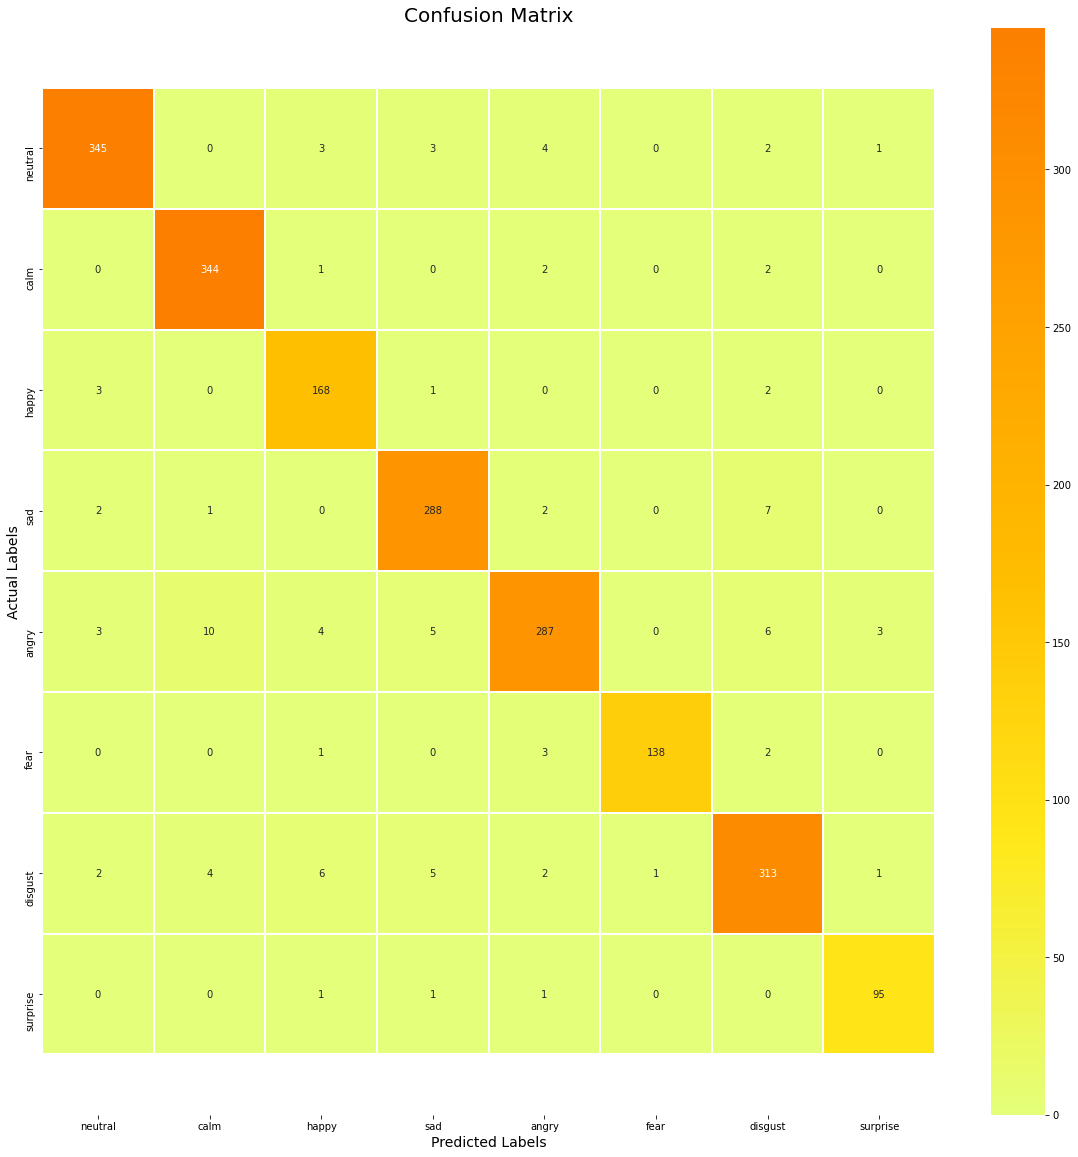

In [44]:
for i in range(0,Y_ac_g.shape[0]):
    if Y_ac_g[i] >= 8:
        Y_ac_g[i] = Y_ac_g[i] -8
    if y_pre_g[i] >= 8:
        y_pre_g[i] = y_pre_g[i] -8
Y_ac1_g = pd.DataFrame(Y_ac_g)
y_pre1_g = pd.DataFrame(y_pre_g)
Y_ac1_g = Y_ac1_g.replace({0:"neutral", 1:"calm", 2:"happy", 3:"sad", 4:"angry", 5:"fear", 6:"disgust", 7:"surprise"})
y_pre1_g = y_pre1_g.replace({0:"neutral", 1:"calm", 2:"happy", 3:"sad", 4:"angry", 5:"fear", 6:"disgust", 7:"surprise"})
cm = confusion_matrix(Y_ac1_g, y_pre1_g)
plt.figure(figsize = (20, 20))
conf_matrix= pd.DataFrame(cm,index=target_names, columns=target_names)
ax = sns.heatmap(conf_matrix, linecolor='white', cmap='Wistia', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [45]:
cr=classification_report(Y_ac_g, y_pre_g)
print(classification_report(Y_ac_g, y_pre_g,digits=4, target_names=target_names))
report = classification_report(Y_ac_g, y_pre_g, digits=4, target_names=target_names, output_dict=True)
cr = pd.DataFrame(report).transpose()
cr.to_csv("result_gender.csv", index= True)

              precision    recall  f1-score   support

     neutral     0.9928    0.9583    0.9753       144
        calm     0.9582    0.9857    0.9718       349
       happy     0.9535    0.9025    0.9273       318
         sad     0.9371    0.9371    0.9371       334
       angry     0.9718    0.9637    0.9677       358
        fear     0.9505    0.9600    0.9552       300
     disgust     0.9130    0.9655    0.9385       174
    surprise     0.9500    0.9694    0.9596        98

    accuracy                         0.9533      2075
   macro avg     0.9534    0.9553    0.9541      2075
weighted avg     0.9536    0.9533    0.9532      2075



In [47]:
male_emo=np.zeros(8,int)
female_emo=np.zeros(8,int)
male_emo_pred=np.zeros(8,int)
female_emo_pred=np.zeros(8,int)
for i in range(0,Y_ac_g.shape[0]):
    if (gender[i]%2)==0:
        flag1 = y_pre_g[i]
        female_emo_pred[flag1] = female_emo_pred[flag1] + 1
        flag2 = Y_ac_g[i]
        female_emo[flag2] = female_emo[flag2] + 1
    if (gender[i]%2)==1:
        flag1 = y_pre_g[i]
        male_emo_pred[flag1] = male_emo_pred[flag1] + 1
        flag2 = Y_ac_g[i]
        male_emo[flag2] = male_emo[flag2] + 1
print(male_emo)
print(female_emo)
print(male_emo_pred)
print(female_emo_pred)

[ 72 173 162 165 175 148  85  42]
[ 72 176 156 169 183 152  89  56]
[ 69 176 156 173 172 147  87  42]
[ 70 183 145 161 183 156  97  58]


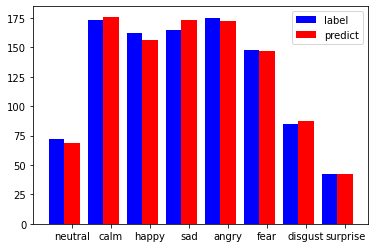

In [48]:
name_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
x =list(range(len(male_emo)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, male_emo, width=width, label='label',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, male_emo_pred, width=width, label='predict',tick_label = name_list,fc = 'r')
plt.legend()

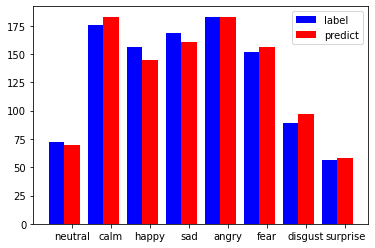

In [50]:
name_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
x =list(range(len(female_emo)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, female_emo, width=width, label='label',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, female_emo_pred, width=width, label='predict',tick_label = name_list,fc = 'r')
plt.legend()

In [49]:
from random import randint
idx=randint(0, 415-1)
print(test.iloc[idx])
im=X_test[idx]
im = im.to(device)
im= (im-mean) / std
im=im.view(1,128,259).unsqueeze(dim=1)

scores =  net(im) 
print(scores)

gender                                                            22
emotion_code                                                       4
emotion                                                          sad
actor                                                             22
path               /Users/xx/Desktop/5452 pro/RAVDESS/03-02-04-01...
mel_spectrogram    [[-59.187237, -61.427635, -63.136707, -59.4075...
Name: 2326, dtype: object
tensor([[  8.9628,   6.4718,   8.4127,  14.4924,   8.7511,  12.1140,  -1.3066,
          -0.4594,  -5.0336, -10.7512,  -8.1836,  -3.1760,  -3.6538,  -3.0057,
          -4.8916,  -4.8913]], grad_fn=<AddmmBackward0>)
